## Data Preprocessing

In [1]:
import torch
import numpy as np
import random

seed = 599

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

lstm_num_hidden_dimensions = 128

In [2]:
from datasets import load_dataset
from pandas import DataFrame as df

raw_datasets = load_dataset("conll2003")

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
example_entry = raw_datasets["train"][4]

In [5]:
ner_feature = raw_datasets["train"].features["ner_tags"]
feature_names = ner_feature.feature.names

In [6]:
tokens = example_entry["tokens"]
tag_ids = example_entry["ner_tags"]
tags = map(lambda tag_id: feature_names[tag_id], tag_ids)

df(zip(tokens, tag_ids, tags))

,0,1,2
0,Germany,5,B-LOC
1,'s,0,O
2,representative,0,O
3,to,0,O
4,the,0,O
5,European,3,B-ORG
6,Union,4,I-ORG
7,'s,0,O
8,veterinary,0,O
9,committee,0,O


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [8]:
tokenizer.is_fast

True

In [9]:
inputs = tokenizer(tokens, is_split_into_words=True, truncation=True)
# inputs = tokenizer(tokens)
# df(inputs.tokens())

In [10]:
# inputs.word_ids()

In [11]:
# df(zip(inputs.tokens(), inputs.word_ids()))

In [12]:
from typing import List


def align_labels_with_split_tokens(
    labels_for_word_id: List[int], word_ids: List[int]
) -> List[str]:
    """
    Given the map from id of each original word to the orignal label
    and the word_ids list indicating how the tokenizer split each word,
    return labels for the tokenized sentence, with word parts
    padded as "inside".

    For example, if LAMB (B-ORG) is split into LA and ##MB,
    label LA as B-ORG and ##MB as I-ORG.
    """
    output = []
    prev_word = None
    for word_id in word_ids:
        if word_id is None:
            # [CLS] or [SEP]
            new_tag_id = -100

        else:
            original_tag_id = labels_for_word_id[word_id]
            if word_id != prev_word:
                # New word.
                # Use the exact same tag id.
                new_tag_id = original_tag_id

            else:
                # Non-leading part of a word that was split.
                # Flip any "B-" (odd label id) into "I-" (by adding 1.)
                if original_tag_id % 2 == 1:
                    new_tag_id = original_tag_id + 1
                else:
                    new_tag_id = original_tag_id

        output.append(new_tag_id)

        prev_word = word_id

    return output

In [13]:
new_feature_names = dict(enumerate(feature_names))
new_feature_names[-100] = "SPECIAL"

In [14]:
new_labels = align_labels_with_split_tokens(tag_ids, inputs.word_ids())

new_tags = map(lambda tag_id: new_feature_names[tag_id], new_labels)

df(zip(inputs.tokens(), inputs.word_ids(), new_labels, new_tags))

,0,1,2,3
0,[CLS],NaN,-100,SPECIAL
1,Germany,0.0,5,B-LOC
2,',1.0,0,O
3,s,1.0,0,O
4,representative,2.0,0,O
5,to,3.0,0,O
6,the,4.0,0,O
7,European,5.0,3,B-ORG
8,Union,6.0,4,I-ORG
9,',7.0,0,O


### Apply to the entire dataset

In [15]:
# Peek at "tokens".
df(raw_datasets["train"]["tokens"])

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,EU,rejects,German,call,to,boycott,British,lamb,.,None,...,None,None,None,None,None,None,None,None,None,None
1,Peter,Blackburn,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,BRUSSELS,1996-08-22,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,The,European,Commission,said,on,Thursday,it,disagreed,with,German,...,None,None,None,None,None,None,None,None,None,None
4,Germany,'s,representative,to,the,European,Union,'s,veterinary,committee,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14036,on,Friday,:,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14037,Division,two,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14038,Plymouth,2,Preston,1,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
14039,Division,three,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [16]:
def tokenize_and_align(examples):
    """
    Given a list of sentences
    and a list of token ids, output a dataset of the tokenized
    features and the properly-aligned labels.
    """

    list_of_sentences_of_tokens = examples["tokens"]
    list_of_sentences_of_tag_ids = examples["ner_tags"]

    tokenized_inputs = tokenizer(
        list_of_sentences_of_tokens,
        truncation=True,
        # Truncate to the maximum possible length of the model.
        is_split_into_words=True,
    )

    list_of_aligned_tags_ids = []

    for (sentence_index, tag_ids) in enumerate(list_of_sentences_of_tag_ids):
        token_ids = tokenized_inputs.word_ids(sentence_index)
        aligned_tag_ids = align_labels_with_split_tokens(tag_ids, token_ids)
        list_of_aligned_tags_ids.append(aligned_tag_ids)

    tokenized_inputs["labels"] = list_of_aligned_tags_ids
    return tokenized_inputs

In [17]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align, batched=True, remove_columns=raw_datasets["train"].column_names
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-e2bdf12298118e1f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-cf59fcf3af23ec85.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6/cache-14e79b8a8a1f0fed.arrow


In [18]:
def get_tokenized_sentence(dataset_entry):
    """
    Given a data sentence entry (a sentence),
    return a tokenized list of words from that sentence.
    """
    words = dataset_entry["tokens"]
    tokenized_words = tokenizer(
        words, is_split_into_words=True, truncation=True
    ).tokens()
    return tokenized_words

## Data Collation, Data Loader, and Metrics

In [19]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    batch_size=32,
)

In [21]:
from datasets import load_metric

metric = load_metric("seqeval")

In [22]:
import torch.nn as nn

loss_fct = nn.CrossEntropyLoss(ignore_index=-100)

## Model

### Define Model Classes and Util Functions

In [23]:
import torch
from torch import nn
from transformers import BertModel, BertConfig


class CustomModel(nn.Module):
    def __init__(self, bert_config, bilstm_dimension=256, include_transformer=False):
        super(CustomModel, self).__init__()

        self.include_transformer = include_transformer
        self.bert = BertModel(bert_config)

        # While pre-trained BERT includes both an embedder and a
        # context-aware pre-trained transformer,
        # include only the embedder if include_transformer = False.
        bert_layers = list(self.bert.children())
        self.bert_embedder = bert_layers[0]

        # Freeze BERT weights in both the embeddings and the transformer.
        for parameter in self.bert.parameters():
            parameter.requires_grad = False

        self.dropout = nn.Dropout(bert_config.hidden_dropout_prob)

        self.bilstm = nn.LSTM(
            bert_config.hidden_size,
            bilstm_dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(bilstm_dimension * 2, bert_config.num_labels)

    def get_trainable_parameters(self):
        return list(self.bilstm.parameters()) + list(self.linear.parameters())

    def forward(self, **batch):
        if self.include_transformer:
            bert_embedding = self.bert(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
            )[0]
        else:
            bert_embedding = self.bert_embedder(
                input_ids=batch["input_ids"],
                # attention_mask=batch["attention_mask"],
                # The embedder is supposed to ignore paddings.
                token_type_ids=batch["token_type_ids"],
            )

        bilstm_embedding = self.bilstm(bert_embedding)[0]
        bilstm_embedding = self.dropout(bilstm_embedding)

        output = self.linear(
            bilstm_embedding
        )  # (batch_size, padded_sentence_length, num_categories)

        return output


bert_config = BertConfig.from_pretrained(
    "bert-base-cased", num_labels=len(feature_names)
)

In [24]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[feature_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [feature_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [25]:
def postprocess(predictions, labels):
    predictions = predictions  # .cpu().clone().numpy()
    labels = labels  # .cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    truncated_labels = [
        [feature_names[l] for l in label if l != -100] for label in labels
    ]
    # truncated_predictions = [
    #     [feature_names[p] for (p, l) in zip(prediction, label) if l != -100]
    #     for prediction, label in zip(predictions, labels)
    # ]
    truncated_predictions = []

    for sentence_predictions, sentence_labels in zip(predictions, labels):
        sentence_paired = []
        for prediction, label in zip(sentence_predictions, sentence_labels):
            prediction_index = torch.argmax(prediction).cpu()
            if label != -100:
                sentence_paired.append(feature_names[prediction_index])

        truncated_predictions.append(sentence_paired)

    return truncated_labels, truncated_predictions

### Model- Baseline (No Transformer)

#### Instantiate Model

In [26]:
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler

#
model_no_transformer = CustomModel(bert_config, include_transformer=False, bilstm_dimension=lstm_num_hidden_dimensions)
optimizer = AdamW(model_no_transformer.parameters())

#
accelerator = Accelerator()
(
    model_no_transformer,
    optimizer,
    train_dataloader,
    eval_dataloader,
) = accelerator.prepare(
    model_no_transformer, optimizer, train_dataloader, eval_dataloader
)

# Scheduler
num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
print(num_training_steps)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

4390


#### Train Model

In [27]:
from tqdm.auto import tqdm
import torch
import pprint

progress_bar = tqdm(range(num_training_steps))
all_results = []  # List of metrics, one for each epoch.


for epoch in range(num_train_epochs):
    model_no_transformer.train()
    for batch in train_dataloader:
        outputs = model_no_transformer(**batch)
        loss = loss_fct(
            outputs.reshape(-1, len(feature_names)), batch["labels"].flatten()
        )
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model_no_transformer.eval()

    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            predictions = model_no_transformer(**batch)

        labels = batch["labels"]

        predictions = accelerator.pad_across_processes(
            predictions, dim=1, pad_index=len(feature_names) - 1
        )
        labels = accelerator.pad_across_processes(
            labels, dim=1, pad_index=len(feature_names) - 1
        )

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_labels, prediction_labels = postprocess(
            predictions_gathered, labels_gathered
        )
        metric.add_batch(predictions=prediction_labels, references=true_labels)

    # print(metric)
    # print(prediction_labels)
    results = metric.compute()
    print(f"Epoch {epoch}: overall accuracy {results['overall_accuracy']}")
    pprint.pprint(results)
    all_results.append(results)

pprint.pprint(results)

accelerator.wait_for_everyone()

unwrapped_model_no_transformer = accelerator.unwrap_model(model_no_transformer)

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 0: overall accuracy 0.8484429269441337
{'LOC': {'f1': 0.5084745762711864,
         'number': 1837,
         'precision': 0.6162790697674418,
         'recall': 0.4327708219923789},
 'MISC': {'f1': 0.02631578947368421,
          'number': 922,
          'precision': 0.09859154929577464,
          'recall': 0.015184381778741865},
 'ORG': {'f1': 0.22725611983924002,
         'number': 1341,
         'precision': 0.22277936962750716,
         'recall': 0.2319164802386279},
 'PER': {'f1': 0.3128220672931191,
         'number': 1842,
         'precision': 0.35415236787920384,
         'recall': 0.28013029315960913},
 'overall_accuracy': 0.8484429269441337,
 'overall_f1': 0.319937420553437,
 'overall_precision': 0.3817969661610268,
 'overall_recall': 0.27532817233254797}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1: overall accuracy 0.8864131394595868
{'LOC': {'f1': 0.6097111247695144,
         'number': 1837,
         'precision': 0.7000705716302047,
         'recall': 0.5400108873162766},
 'MISC': {'f1': 0.30154277699859744,
          'number': 922,
          'precision': 0.42658730158730157,
          'recall': 0.23318872017353579},
 'ORG': {'f1': 0.3496271748135874,
         'number': 1341,
         'precision': 0.3932898415657036,
         'recall': 0.31469052945563014},
 'PER': {'f1': 0.45985010706638113,
         'number': 1842,
         'precision': 0.4535374868004224,
         'recall': 0.46634093376764385},
 'overall_accuracy': 0.8864131394595868,
 'overall_f1': 0.4594644506001847,
 'overall_precision': 0.5090016366612111,
 'overall_recall': 0.4187142376304275}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2: overall accuracy 0.9023517984340966
{'LOC': {'f1': 0.6740629685157421,
         'number': 1837,
         'precision': 0.7503337783711616,
         'recall': 0.6118671747414263},
 'MISC': {'f1': 0.4385221078134464,
          'number': 922,
          'precision': 0.49657064471879286,
          'recall': 0.3926247288503254},
 'ORG': {'f1': 0.4091097308488613,
         'number': 1341,
         'precision': 0.45996275605214154,
         'recall': 0.36838180462341535},
 'PER': {'f1': 0.49424979941160735,
         'number': 1842,
         'precision': 0.4870848708487085,
         'recall': 0.501628664495114},
 'overall_accuracy': 0.9023517984340966,
 'overall_f1': 0.5213644524236984,
 'overall_precision': 0.5586764140053867,
 'overall_recall': 0.4887243352406597}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3: overall accuracy 0.9117854830164244
{'LOC': {'f1': 0.7065868263473054,
         'number': 1837,
         'precision': 0.7419161676646706,
         'recall': 0.6744692433315188},
 'MISC': {'f1': 0.478310502283105,
          'number': 922,
          'precision': 0.5048192771084338,
          'recall': 0.4544468546637744},
 'ORG': {'f1': 0.4295161851722938,
         'number': 1341,
         'precision': 0.4027415143603133,
         'recall': 0.4601043997017151},
 'PER': {'f1': 0.5488642366613841,
         'number': 1842,
         'precision': 0.5344650205761317,
         'recall': 0.5640608034744843},
 'overall_accuracy': 0.9117854830164244,
 'overall_f1': 0.5561335794596409,
 'overall_precision': 0.5545515394912985,
 'overall_recall': 0.5577246718276675}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4: overall accuracy 0.9181580031789015
{'LOC': {'f1': 0.7086788280818132,
         'number': 1837,
         'precision': 0.7198203256597417,
         'recall': 0.6978769733260751},
 'MISC': {'f1': 0.518431831480398,
          'number': 922,
          'precision': 0.5628970775095299,
          'recall': 0.4804772234273319},
 'ORG': {'f1': 0.4794572182434979,
         'number': 1341,
         'precision': 0.4847560975609756,
         'recall': 0.4742729306487696},
 'PER': {'f1': 0.5629589339135165,
         'number': 1842,
         'precision': 0.5640326975476839,
         'recall': 0.5618892508143323},
 'overall_accuracy': 0.9181580031789015,
 'overall_f1': 0.5826541991936176,
 'overall_precision': 0.594225721784777,
 'overall_recall': 0.571524739145069}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5: overall accuracy 0.9143168305174545
{'LOC': {'f1': 0.7347057118005219,
         'number': 1837,
         'precision': 0.7859801488833746,
         'recall': 0.6897114861186717},
 'MISC': {'f1': 0.5355850422195416,
          'number': 922,
          'precision': 0.6032608695652174,
          'recall': 0.48156182212581344},
 'ORG': {'f1': 0.48378481495612363,
         'number': 1341,
         'precision': 0.4953125,
         'recall': 0.4727815063385533},
 'PER': {'f1': 0.5237401689484416,
         'number': 1842,
         'precision': 0.5650534255185418,
         'recall': 0.48805646036916395},
 'overall_accuracy': 0.9143168305174545,
 'overall_f1': 0.5813099184660873,
 'overall_precision': 0.6215750143705691,
 'overall_recall': 0.5459441265567149}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6: overall accuracy 0.9263112968740802
{'LOC': {'f1': 0.7453854505971769,
         'number': 1837,
         'precision': 0.7433676231727125,
         'recall': 0.7474142623843223},
 'MISC': {'f1': 0.559906487434249,
          'number': 922,
          'precision': 0.6070975918884665,
          'recall': 0.5195227765726681},
 'ORG': {'f1': 0.5183431952662721,
         'number': 1341,
         'precision': 0.550251256281407,
         'recall': 0.4899328859060403},
 'PER': {'f1': 0.6013330041964946,
         'number': 1842,
         'precision': 0.5513807152557718,
         'recall': 0.6612377850162866},
 'overall_accuracy': 0.9263112968740802,
 'overall_f1': 0.6221517402554043,
 'overall_precision': 0.6171551581387646,
 'overall_recall': 0.6272298889262874}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7: overall accuracy 0.9272237593453818
{'LOC': {'f1': 0.7524696584815128,
         'number': 1837,
         'precision': 0.7813599062133646,
         'recall': 0.7256396298312466},
 'MISC': {'f1': 0.5804154302670623,
          'number': 922,
          'precision': 0.6408912188728703,
          'recall': 0.5303687635574837},
 'ORG': {'f1': 0.5289062499999999,
         'number': 1341,
         'precision': 0.5553732567678425,
         'recall': 0.5048471290082028},
 'PER': {'f1': 0.5981259760541385,
         'number': 1842,
         'precision': 0.5745,
         'recall': 0.6237785016286646},
 'overall_accuracy': 0.9272237593453818,
 'overall_f1': 0.6273430782459156,
 'overall_precision': 0.6413502109704642,
 'overall_recall': 0.6139347021204982}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8: overall accuracy 0.9281362218166833
{'LOC': {'f1': 0.7636363636363637,
         'number': 1837,
         'precision': 0.7985739750445633,
         'recall': 0.7316276537833424},
 'MISC': {'f1': 0.5927152317880795,
          'number': 922,
          'precision': 0.6033707865168539,
          'recall': 0.5824295010845987},
 'ORG': {'f1': 0.5269031486648067,
         'number': 1341,
         'precision': 0.5659246575342466,
         'recall': 0.4929157345264728},
 'PER': {'f1': 0.60625,
         'number': 1842,
         'precision': 0.5825825825825826,
         'recall': 0.6319218241042345},
 'overall_accuracy': 0.9281362218166833,
 'overall_f1': 0.6345347144936222,
 'overall_precision': 0.6457571005401638,
 'overall_recall': 0.6236957253450017}


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9: overall accuracy 0.9294018955671984
{'LOC': {'f1': 0.7625174825174825,
         'number': 1837,
         'precision': 0.784234752589183,
         'recall': 0.7419706042460533},
 'MISC': {'f1': 0.5855338691159587,
          'number': 922,
          'precision': 0.6219512195121951,
          'recall': 0.5531453362255966},
 'ORG': {'f1': 0.5420489296636085,
         'number': 1341,
         'precision': 0.556078431372549,
         'recall': 0.5287099179716629},
 'PER': {'f1': 0.6084447941253607,
         'number': 1842,
         'precision': 0.5885337392186707,
         'recall': 0.6297502714440825},
 'overall_accuracy': 0.9294018955671984,
 'overall_f1': 0.6371530733866849,
 'overall_precision': 0.6447277739490007,
 'overall_recall': 0.6297542914843487}
{'LOC': {'f1': 0.7625174825174825,
         'number': 1837,
         'precision': 0.784234752589183,
         'recall': 0.7419706042460533},
 'MISC': {'f1': 0.5855338691159587,
          'number': 922,
          'precision': 0.62

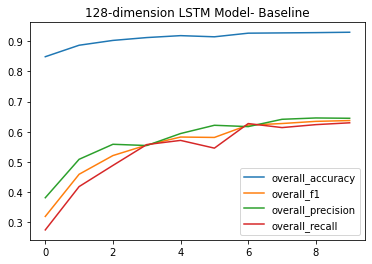

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df


results_table = df(all_results)
for key in ["overall_accuracy", "overall_f1", "overall_precision", "overall_recall"]:
    plt.plot(results_table[key], label=key)

plt.title(f"{lstm_num_hidden_dimensions}-dimension LSTM Model- Baseline")
plt.legend()
plt.show()

#### Run Inference

In [29]:
example_labels_model_no_transformer = []  # (Ground Truth, Predictions)

for batch in tqdm(eval_dataloader):
    with torch.no_grad():
        predictions = model_no_transformer(**batch)

    labels = batch["labels"]

    predictions = accelerator.pad_across_processes(
        predictions, dim=1, pad_index=len(feature_names) - 1
    )
    labels = accelerator.pad_across_processes(
        labels, dim=1, pad_index=len(feature_names) - 1
    )

    predictions_gathered = accelerator.gather(predictions)
    labels_gathered = accelerator.gather(labels)

    true_labels, prediction_labels = postprocess(predictions_gathered, labels_gathered)

    example_labels_model_no_transformer.extend(zip(true_labels, prediction_labels))

  0%|          | 0/102 [00:00<?, ?it/s]

### Model- Experiment (With Transformer)

#### Instantiate Model

In [30]:
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler

#
model_with_transformer = CustomModel(bert_config, include_transformer=True)
optimizer = AdamW(model_with_transformer.parameters())

#
accelerator = Accelerator()
(
    model_with_transformer,
    optimizer,
    train_dataloader,
    eval_dataloader,
) = accelerator.prepare(
    model_with_transformer, optimizer, train_dataloader, eval_dataloader
)

# Scheduler
num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
print(num_training_steps)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

4390


#### Train Model

In [31]:
from tqdm.auto import tqdm
import torch
import pprint

progress_bar = tqdm(range(num_training_steps))
all_results = []  # List of metrics, one for each epoch.

for epoch in range(num_train_epochs):
    model_with_transformer.train()
    for batch in train_dataloader:
        outputs = model_with_transformer(**batch)
        loss = loss_fct(
            outputs.reshape(-1, len(feature_names)), batch["labels"].flatten()
        )
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model_with_transformer.eval()

    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            predictions = model_with_transformer(**batch)

        labels = batch["labels"]

        predictions = accelerator.pad_across_processes(
            predictions, dim=1, pad_index=len(feature_names) - 1
        )
        labels = accelerator.pad_across_processes(
            labels, dim=1, pad_index=len(feature_names) - 1
        )

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_labels, prediction_labels = postprocess(
            predictions_gathered, labels_gathered
        )
        metric.add_batch(predictions=prediction_labels, references=true_labels)

    # print(metric)
    # print(prediction_labels)
    results = metric.compute()
    print(f"Epoch {epoch}: overall accuracy {results['overall_accuracy']}")
    # pprint.pprint(results)
    all_results.append(results)

pprint.pprint(results)

accelerator.wait_for_everyone()
unwrapped_model_with_transformer = accelerator.unwrap_model(model_with_transformer)

  0%|          | 0/4390 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0: overall accuracy 0.8109730970742333


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 1: overall accuracy 0.8379201742508977


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 2: overall accuracy 0.8466621534114323


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 3: overall accuracy 0.8635427091305116


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 4: overall accuracy 0.8693854123741684


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 5: overall accuracy 0.8787307941366927


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 6: overall accuracy 0.8842644375110379


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 7: overall accuracy 0.8897980808853829


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 8: overall accuracy 0.891505268734915


  0%|          | 0/102 [00:00<?, ?it/s]

Epoch 9: overall accuracy 0.8933890622240537
{'LOC': {'f1': 0.6267840874582449,
         'number': 1837,
         'precision': 0.7087912087912088,
         'recall': 0.5617855198693522},
 'MISC': {'f1': 0.32848232848232845,
          'number': 922,
          'precision': 0.45489443378119004,
          'recall': 0.25704989154013014},
 'ORG': {'f1': 0.4041867954911433,
         'number': 1341,
         'precision': 0.43919510061242345,
         'recall': 0.3743475018642804},
 'PER': {'f1': 0.5071796261175834,
         'number': 1842,
         'precision': 0.5062195781503516,
         'recall': 0.50814332247557},
 'overall_accuracy': 0.8933890622240537,
 'overall_f1': 0.49619649894601775,
 'overall_precision': 0.5447776212517609,
 'overall_recall': 0.45557051497812184}


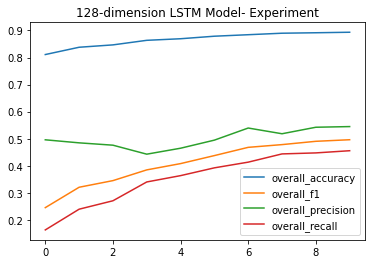

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame as df


results_table = df(all_results)
for key in ["overall_accuracy", "overall_f1", "overall_precision", "overall_recall"]:
    plt.plot(results_table[key], label=key)

plt.title(f"{lstm_num_hidden_dimensions}-dimension LSTM Model- Experiment")
plt.legend()
plt.show()

In [33]:
example_labels_model_with_transformer = []  # (Ground Truth, Predictions)

for batch in tqdm(eval_dataloader):
    with torch.no_grad():
        predictions = model_with_transformer(**batch)

    labels = batch["labels"]

    predictions = accelerator.pad_across_processes(
        predictions, dim=1, pad_index=len(feature_names) - 1
    )
    labels = accelerator.pad_across_processes(
        labels, dim=1, pad_index=len(feature_names) - 1
    )

    predictions_gathered = accelerator.gather(predictions)
    labels_gathered = accelerator.gather(labels)

    true_labels, prediction_labels = postprocess(predictions_gathered, labels_gathered)

    example_labels_model_with_transformer.extend(zip(true_labels, prediction_labels))

  0%|          | 0/102 [00:00<?, ?it/s]

### Data output

In [ ]:
tokenized_sentences = list(map(get_tokenized_sentence, raw_datasets["validation"]))

# List of strings, one for each line in the output.
output = [
    " ".join(
        [
            "token",
            "ground_truth",
            "predicted_no_transformer",
            "predicted_with_transformer",
            "\n",
        ]
    )
]

for (
    sentence,
    (ground_truth_labels, predicted_labels_model_no_transformer),
    (_, predicted_labels_model_with_transformer),
) in zip(
    tokenized_sentences,
    example_labels_model_no_transformer,
    example_labels_model_with_transformer,
):
    for (
        token,
        ground_truth_label,
        predicted_label_model_no_transformer,
        predicted_label_model_with_transformer,
    ) in zip(
        sentence[1:-1],
        ground_truth_labels,
        predicted_labels_model_no_transformer,
        predicted_labels_model_with_transformer,
    ):
        line = f"{token} {ground_truth_label} {predicted_label_model_no_transformer} {predicted_label_model_with_transformer}\n"
        output.append(line)

    output.append("\n")

with open(f"eval-bert-base-cased-output-lstm-{lstm_num_hidden_dimensions}.csv", "w") as output_file:
    output_file.writelines(output)